In [47]:
import pandas as pd
#import bambi as bmb
import pingouin as pg
import joblib
from os import listdir
from os.path import join
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az


sns.set_style('ticks')
sns.set_context('poster')

%matplotlib inline

INDIR = '/mnt/obob/staff/fschmidt/cardiac_1_f/data/c_1_f_resting_sbg'
my_freqs = '_1_200_thr_0.7'
all_files = [file for file in listdir(INDIR) if my_freqs in file]
len(all_files)

685

In [48]:
all_df, all_psd = [], []
for file in all_files:
    cur_data = joblib.load(join(INDIR, file))
    
    if 'ecg_scores' in cur_data.keys() and (cur_data['ecg_scores'] > 0.7).sum() > 0:
    
        def make_data_meg(cur_data, key):
            cur_psd = pd.DataFrame(cur_data['psd'])#.mean(axis=0))
            cur_psd['channel'] = np.arange(102)
            psd_melt = cur_psd.melt(id_vars='channel')
            psd_melt['Frequency (Hz)'] = psd_melt['variable'].replace(dict(zip(np.arange(cur_data['freqs']), cur_data['freqs'])))
            psd_melt.drop(labels='variable', axis=1, inplace=True)
            psd_melt.columns = ['channel', key, 'Frequency (Hz)']
            return psd_melt

        mags_df = make_data_meg(cur_data['data_brain']['mag'], 'Magnetometers (ECG removed)')
        mags_heart_df = make_data_meg(cur_data['data_heart']['mag'], 'ECG Component Magnetometers')
        mags_no_ica_df = make_data_meg(cur_data['data_no_ica']['mag'], 'Magnetometers (ECG present)')

        df_meg_cmb = mags_df.merge(mags_heart_df, on=['channel', 'Frequency (Hz)'])
        df_meg_cmb = df_meg_cmb.merge(mags_no_ica_df, on=['channel', 'Frequency (Hz)'])                    
        df_ecg = pd.DataFrame({'ECG Electrode' : cur_data['data_heart']['ecg']['psd'][0,:][0],
                               'Frequency (Hz)': cur_data['data_heart']['ecg']['freqs'],})
        
        df_psd = df_meg_cmb.merge(df_ecg, on='Frequency (Hz)')
        df_psd['subject_id'] = cur_data['subject_id']
        df_psd['age'] = cur_data['age']
        all_psd.append(df_psd)

    
        all_df.append(pd.DataFrame({'heart_slope_mag': cur_data['data_heart']['mag']['exponents'],
                                'brain_slope': cur_data['data_brain']['mag']['exponents'],
                                'brain_no_ica': cur_data['data_no_ica']['mag']['exponents'],
                                'heart_slope': cur_data['data_heart']['ecg']['exponents'][0],
                                'heart_slope_avg': cur_data['data_heart']['mag']['aps_mag']['Exponent'].mean(),
                                'brain_slope_avg': cur_data['data_brain']['mag']['aps_mag']['Exponent'].mean(),
                                'no_ica_slope_avg': cur_data['data_no_ica']['mag']['aps_mag']['Exponent'].mean(),
                                'channel': np.arange(102),
                                'subject_id': cur_data['subject_id'],
                                'age': cur_data['age'],
                                'meas_date': cur_data['meas_date'],
                                'days': cur_data['days']}))
df_cmb = pd.concat(all_df)
df_cmb_psd = pd.concat(all_psd)

In [49]:
avg_psd = df_cmb_psd.groupby(['Frequency (Hz)', 'channel']).mean().reset_index()
df_cmb_psd

,channel,Magnetometers (ECG removed),Frequency (Hz),ECG Component Magnetometers,Magnetometers (ECG present),ECG Electrode,subject_id,age
0,0,7.491879e-26,1.0,1.530025e-27,7.951712e-26,1.970645e-08,19620826wlti,54
1,1,7.039298e-26,1.0,1.815268e-28,1.056573e-25,1.970645e-08,19620826wlti,54
2,2,3.565219e-26,1.0,7.515178e-29,3.909809e-26,1.970645e-08,19620826wlti,54
3,3,3.447843e-26,1.0,1.143880e-27,3.490311e-26,1.970645e-08,19620826wlti,54
4,4,3.184563e-26,1.0,2.055880e-29,3.224203e-26,1.970645e-08,19620826wlti,54
...,...,...,...,...,...,...,...,...
30595,97,1.284449e-29,150.5,7.844823e-31,1.407438e-29,4.959208e-08,19990303hlas,21
30596,98,7.800297e-30,150.5,3.613214e-31,8.194935e-30,4.959208e-08,19990303hlas,21
30597,99,8.004437e-30,150.5,8.146824e-31,7.780029e-30,4.959208e-08,19990303hlas,21
30598,100,8.417248e-30,150.5,9.625595e-31,8.551122e-30,4.959208e-08,19990303hlas,21


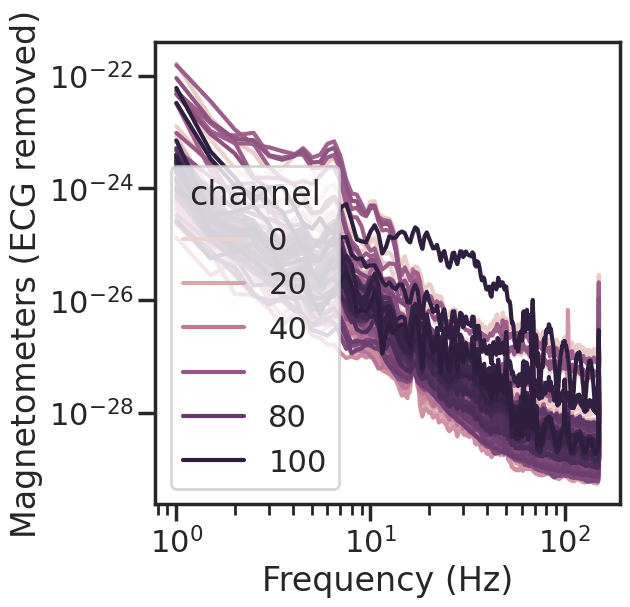

In [50]:
#%%
fig, ax = plt.subplots()
sns.lineplot(x='Frequency (Hz)', y='Magnetometers (ECG removed)',
             hue="channel",
             data=avg_psd, ax=ax)
fig.set_size_inches(6,6)
plt.xscale('log')
plt.yscale('log')
#fig.savefig(f'../results/mags_ga_ecg_removed{my_freqs}.svg')
#%%


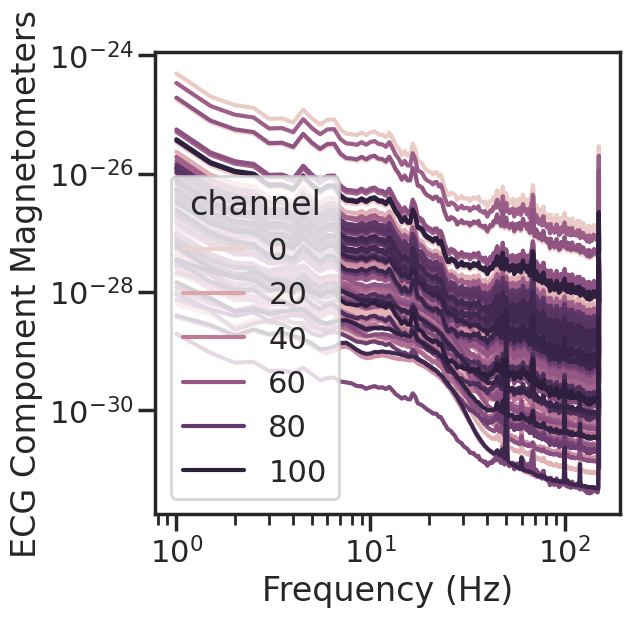

In [51]:
fig, ax = plt.subplots()
sns.lineplot(x='Frequency (Hz)', y='ECG Component Magnetometers',
             hue="channel",
             data=avg_psd, ax=ax)
fig.set_size_inches(6,6)
plt.xscale('log')
plt.yscale('log')
#fig.savefig(f'../results/mags_ga_ecg_component{my_freqs}.svg')
#%%


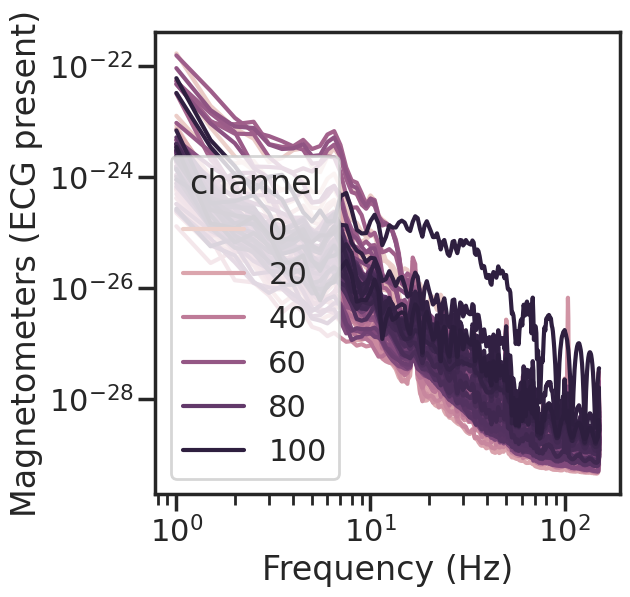

In [52]:
fig, ax = plt.subplots()
sns.lineplot(x='Frequency (Hz)', y='Magnetometers (ECG present)',
             hue="channel",
             data=avg_psd, ax=ax)
fig.set_size_inches(6,6)
plt.xscale('log')
plt.yscale('log')
#fig.savefig(f'../results/mags_ga_ecg_present{my_freqs}.svg')

In [53]:
# %%
df_cmb.to_csv('../data/sbg_1_f_dataframe_1_200.csv')

In [54]:
cur_df_cmb = df_cmb.query('channel == 0')


def plot_slope_age_corr(key, x, y, color):
    corr = pg.corr(cur_df_cmb['age'], cur_df_cmb[key])#, method='shepherd')
    print(corr)
    g = sns.lmplot(data=cur_df_cmb, x='age', y=key, 
                    line_kws={'color': color}, 
                    scatter_kws={"s": 40, 'color': '#888888', 'alpha': 0.25})

    r = round(float(corr['r']), 2)
    p = round(float(corr['p-val']), 3)

    if p == 0.0:
        p = 'p < 0.001'
    else:
        p = f'p = {p}'

    plt.annotate(text=f'r = {r}', xy=(x, y))
    plt.annotate(text=p, xy=(x, y - 0.2))

    g.set_xlabels('age (years)')
    g.set_ylabels('1/f slope')
    #g.ax.figure.savefig(f'../results/corr_{key}_{my_freqs}.svg', )

           n        r          CI95%     p-val   BF10     power
pearson  561  0.03576  [-0.05, 0.12]  0.397907  0.076  0.135066


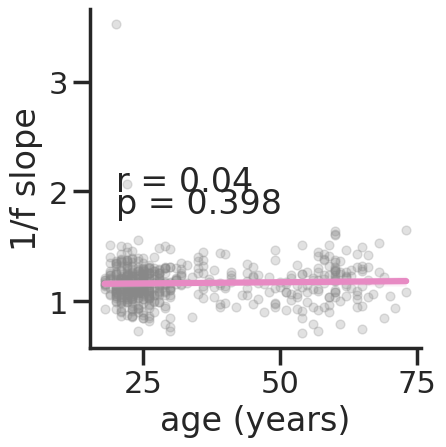

In [55]:
#%%
plot_slope_age_corr('no_ica_slope_avg', 20, 2., '#e78ac3')

           n         r          CI95%     p-val   BF10     power
pearson  561  0.024622  [-0.06, 0.11]  0.560583  0.063  0.089614


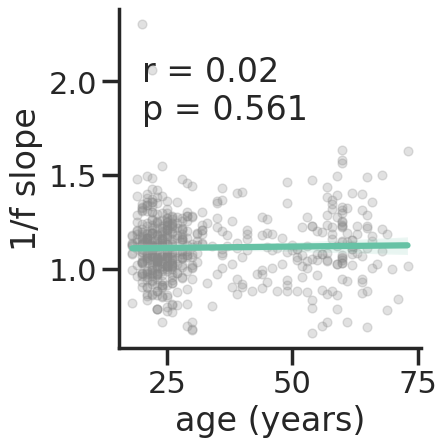

In [56]:
#%%
plot_slope_age_corr('brain_slope_avg', 20, 2., '#66c2a5')

           n         r        CI95%         p-val      BF10     power
pearson  561  0.279051  [0.2, 0.35]  1.710536e-11  3.38e+08  0.999999


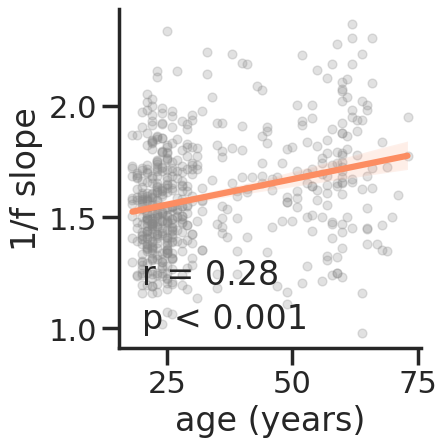

In [57]:
#%%
plot_slope_age_corr('heart_slope_avg', 20, 1.2, '#fc8d62')

           n         r           CI95%     p-val      BF10     power
pearson  561 -0.187509  [-0.27, -0.11]  0.000008  1128.925  0.994234


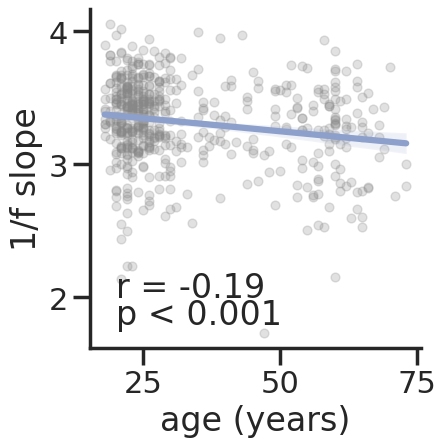

In [58]:
plot_slope_age_corr('heart_slope', 20, 2., '#8da0cb')

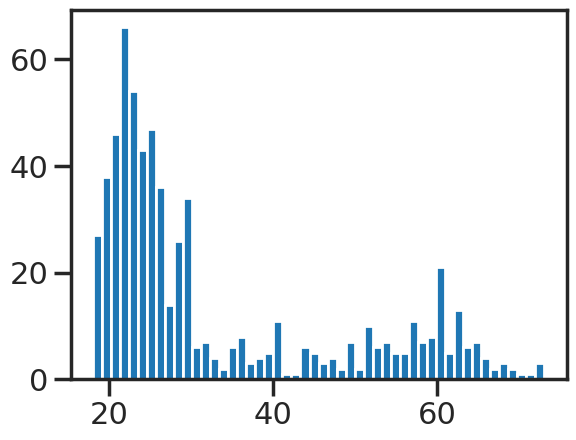

In [34]:
plt.hist(cur_df_cmb['age'], bins=50);

In [40]:
mdf = bmb.Model(data=cur_df_cmb, 
                formula='age ~ brain_slope_avg + heart_slope_avg', 
                dropna=True,
                family='gamma',
                link='log',
                ).fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Intercept, brain_slope_avg, heart_slope_avg, days_alpha]


ValueError: Not enough samples to build a trace.

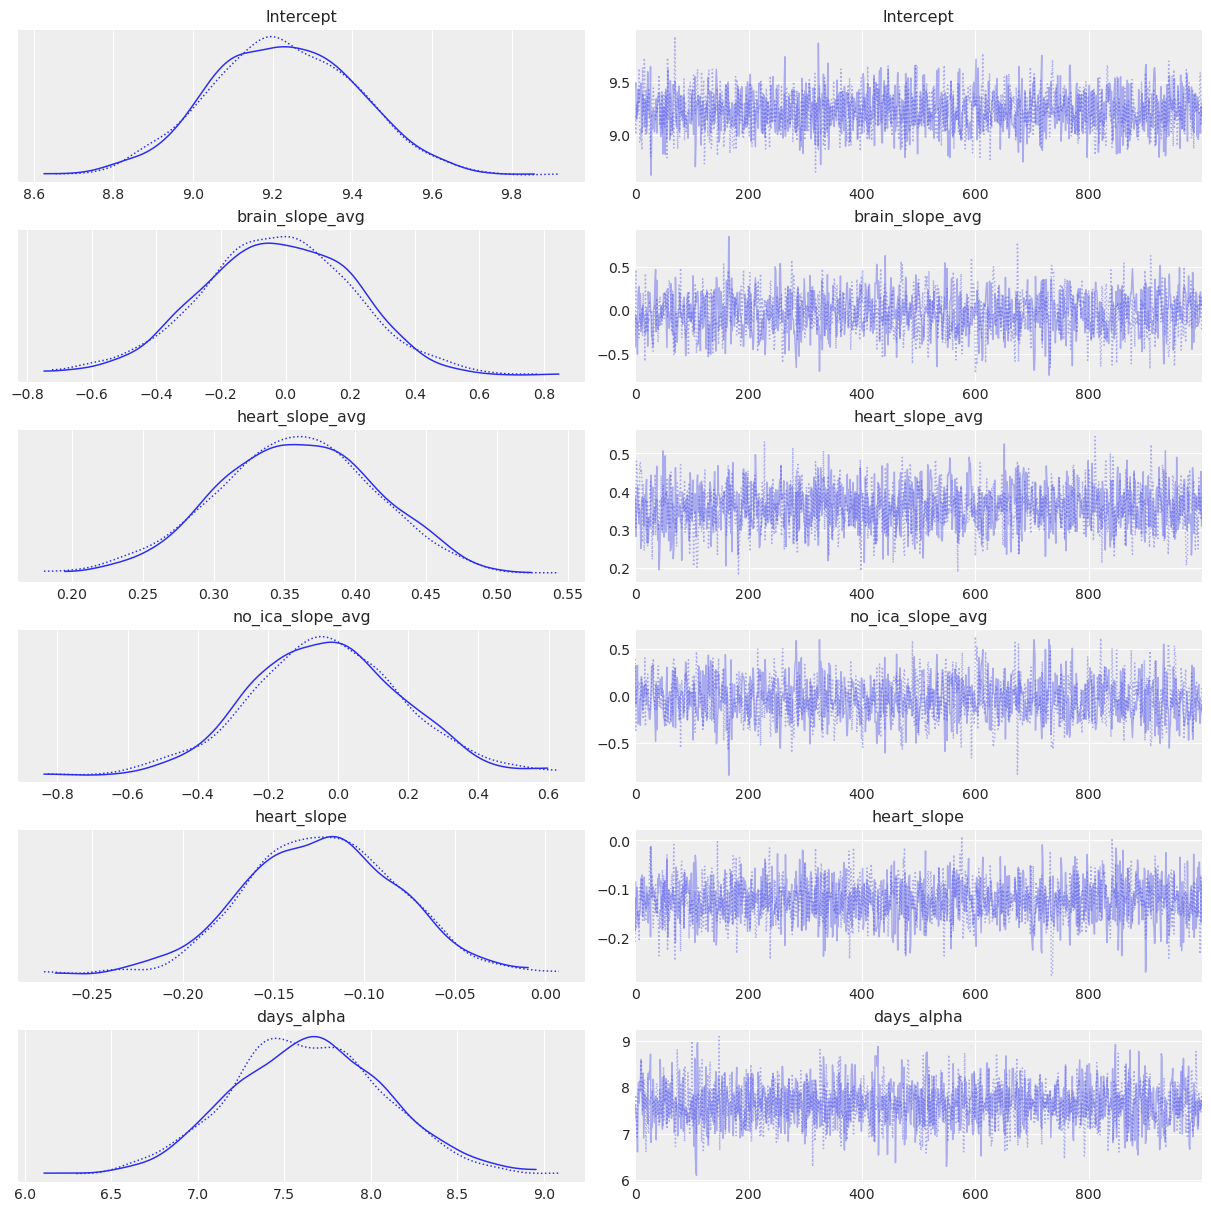

In [1014]:
with az.style.use("arviz-darkgrid"):
    az.plot_trace(mdf);

In [ ]:
az.summary(mdf)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,9.228,0.182,8.866,9.546,0.004,0.003,1904.0,1705.0,1.0
brain_slope_avg,-0.031,0.233,-0.471,0.397,0.006,0.005,1292.0,1325.0,1.0
heart_slope_avg,0.358,0.056,0.254,0.465,0.001,0.001,1670.0,1331.0,1.0
no_ica_slope_avg,-0.031,0.215,-0.465,0.351,0.006,0.005,1294.0,1156.0,1.0
heart_slope,-0.123,0.042,-0.200,-0.046,0.001,0.001,1829.0,1376.0,1.0
days_alpha,7.640,0.443,6.811,8.453,0.010,0.007,1910.0,1240.0,1.0
